In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nnfs
from nnfs.datasets import sine_data, spiral_data
import random
import requests
from NNS import NeuralNetwork as NN #import neural net code from github to reduce copy/pasting
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
import os
import urllib
import urllib.request
from zipfile import ZipFile

# Real Data

## Load the data

In [6]:
# Load the data
URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving as {FILE} ...')
    urllib.request.urlretrieve(URL, FILE)
    
print ( 'Unzipping images...' )
with ZipFile(FILE) as zip_images:
    zip_images.extractall(FOLDER)

print('Done!')

Unzipping images...
Done!


In [17]:
#Show data information
labels = os.listdir( 'fashion_mnist_images/train' )
print (labels)

files = os.listdir( 'fashion_mnist_images/train/0' )
print (files[: 10 ])
print ( len (files))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png']
6000


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  49 135 182 150  59   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  78 255 220 21

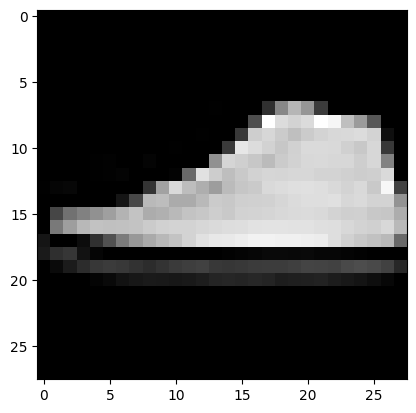

In [14]:
# Display data

import cv2

np.set_printoptions( linewidth = 200 )
image_data = cv2.imread( 'fashion_mnist_images/train/7/0002.png', cv2.IMREAD_UNCHANGED)
print(image_data)

plt.imshow(image_data, cmap='gray')
plt.show()

In [26]:
# Function to loads a MNIST dataset
def load_mnist_dataset(dataset , path):
    
    # Scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path, dataset))
    # Create lists for samples and labels
    
    X = []
    y = []
    
    # For each label folder
    for label in labels:
        # And for each image in given folder
        for file in os.listdir(os.path.join(path, dataset, label)):
            # Read the image
            image = cv2.imread(os.path.join(
                path, dataset, label, file
                ), cv2.IMREAD_UNCHANGED)
            
            # And append it and a label to the lists
            X.append(image)
            y.append(label)
            
    # Convert the data to proper numpy arrays and return
    return np.array(X), np.array(y).astype( 'uint8' )

# MNIST dataset (train + test)
def create_data_mnist ( path ):
    # Load both sets separately
    X, y = load_mnist_dataset( 'train' , path)
    X_test, y_test = load_mnist_dataset( 'test' , path)
    # And return all the data
    return X, y, X_test, y_test

#Create dataset
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

## Data Preprocessing

In [27]:
# Scale features (data is currently [0,255], we scale it to [-1,1])
X = (X.astype(np.float32) - 127.5 ) / 127.5
X_test = (X_test.astype(np.float32) - 127.5 ) / 127.5
print(f"Data Range: {X.min(), X.max()}")

# Flatten the data
print(f"Data Starting Shape: {X.shape}")
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print(f"Data Ending Shape: {X.shape}")


Data Range: (-1.0, 1.0)
Data Starting Shape: (60000, 28, 28)
Data Ending Shape: (60000, 784)


### Data Shuffling

In [28]:
# Our data is currently ordered by their classification, we need to shuffle it for better training
print(f"Starting y head key order: {y[:20]}")
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]
print(f"Ending y head key order: {y[:20]}")

Starting y head key order: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ending y head key order: [1 9 2 3 5 3 2 0 7 1 7 2 4 2 6 5 9 4 4 8]


### Batches
Common batch sizes range between 32 and 128 samples. 
You can go smaller if there are issues fitting everything into memory 
or larger if you want faster training

In general: 

larger batch --> increased accuracy and loss (diminishing returns) 

larger_batch --> slower training


In [ ]:
# Changes to the loss, accuracy, and model classes to account for batching
 
#Common Loss Class
class Loss:
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate ( self, output, y, *, include_regularization = False):
        
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        
        # Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len (sample_losses)
        
        # If just data loss - return it
        if not include_regularization:
            return data_loss
        
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()
    
    # Regularization loss calculation
    def regularization_loss(self):
        
        # 0 by default
        regularization_loss = 0
        
        # Calculate regulariation loss
        # iterate all trainable layers
        
        for layer in self.trainable_layers:
            
            # L1 regularization - weights
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
                
            # L1 regularization - biases
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
                
            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
    # Calculates accumulated loss
    def calculate_accumulated ( self , * , include_regularization = False ):
        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count
        # If just data loss - return it
        if not include_regularization:
            return data_loss
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()
    
    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
        
    # Reset variables for accumulated loss
    def new_pass (self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

# Common Accuracy Class
class Accuracy:
    
    # Calculates an accuracy
    # given prediction and ground truth values
    def calculate(self, predictions, y):
        
        # Get comparison results
        comparisons = self.compare(predictions, y)
        
        # Calculate an accuracy
        accuracy = np.mean(comparisons)
        
        # Add accumulated sum of matching values and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len (comparisons)
        
        # Return accuracy
        return accuracy
    
    # Calculates accumulated accuracy
    def calculate_accumulated ( self ):
        
        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count
        
        # Return the data and regularization losses
        return accuracy
    
    # Reset variables for accumulated accuracy
    def new_pass ( self ):
        self.accumulated_sum = 0
        self.accumulated_count = 0
        
# Model class
class Model :
    
    def __init__ (self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None
        
    # Add objects to the model
    def add (self, layer):
        self.layers.append(layer)
        
    # Set loss, optimizer and accuracy
    def set (self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        
    # Finalize the model
    def finalize (self):
        
        # Create and set the input layer
        self.input_layer = Layer_Input()
        
        # Count all the objects
        layer_count = len(self.layers)
        
        # Initialize a list containing trainable layers:
        self.trainable_layers = []
        
        # Iterate the objects
        for i in range(layer_count):
            
            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0 :
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
                
            # All layers except for the first and the last
            elif i < layer_count - 1 :
                self.layers[i].prev = self.layers[i - 1] 
                self.layers[i].next = self.layers[i + 1]
                
            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else :
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
                
            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
                
                # Update loss object with trainable layers
                self.loss.remember_trainable_layers(
                    self.trainable_layers
                    )
                
                
            # If output activation is Softmax and
            # loss function is Categorical Cross-Entropy
            # create an object of combined activation
            # and loss function containing
            # faster gradient calculation
            if isinstance(self.layers[ - 1 ], Activation_Softmax) and \
                isinstance(self.loss, Loss_CategoricalCrossentropy):
                # Create an object of combined activation
                # and loss functions
                self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()
        
    # Train the model
    def train(self, X, y, *, epochs = 1, batch_size=None, print_every = 1, validation_data = None):
        
        # Initialize accuracy object
        self.accuracy.init(y)
        
        # Default value if batch size is not being set
        train_steps = 1
        
        # If there is validation data passed,
        # set default number of steps for validation as well
        if validation_data is not None :
            validation_steps = 1
            
            # For better readability
            X_val, y_val = validation_data

            # Calculate number of steps
            if batch_size is not None:
                train_steps = len (X) // batch_size
                
                # Dividing rounds down. If there are some remaining
                # data, but not a full batch, this won't include it
                # Add `1` to include this not full batch
                if train_steps * batch_size < len (X):
                    train_steps += 1
                    
                if validation_data is not None :
                    validation_steps = len (X_val) // batch_size
                    # Dividing rounds down. If there are some remaining
                    # data, but nor full batch, this won't include it
                    # Add `1` to include this not full batch
                    if validation_steps * batch_size < len (X_val):
                        validation_steps += 1
        
        # Main training loop
        for epoch in range (1, epochs+1):

            print (f'epoch: {epoch}')
            
            # Reset accumulated values in loss and accuracy objects
            self.loss.new_pass()
            self.accuracy.new_pass()
            
            # Iterate over steps
            for step in range(train_steps):
                
                # If batch size is not set -
                # train using one step and full dataset
                if batch_size is None :
                    batch_X = X
                    batch_y = y
                    
                # Otherwise slice a batch
                else:
                    batch_X = X[step * batch_size:(step + 1 ) * batch_size]
                    batch_y = y[step * batch_size:(step + 1 ) * batch_size]
                    
                # Perform the forward pass
                output = self.forward(batch_X, training = True)
            
                # Calculate loss
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization = True)
                loss = data_loss + regularization_loss
            
                # Get predictions and calculate an accuracy
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)
            
                # Perform backward pass
                self.backward(output, batch_y)
            
                # Optimize (update parameters)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
            
                # Print a summary
                if not step % print_every or step == train_steps - 1:
                    print ( f'epoch: {step} , ' +
                            f'acc: {accuracy :.3f}, ' +
                            f'loss: {loss :.3f} (' +
                            f'data_loss: {data_loss :.3f} , ' +
                            f'reg_loss: {regularization_loss :.3f}), ' +
                            f'lr: {self.optimizer.current_learning_rate}')
                    
            # Get and print epoch loss and accuracy
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(
                include_regularization = True)
            
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            
            print ( f'training, ' +
                    f'acc: {epoch_accuracy :.3f}, ' +
                    f'loss: {epoch_loss :.3f} (' +
                    f'data_loss: {epoch_data_loss :.3f}, ' +
                    f'reg_loss: {epoch_regularization_loss :.3f} ), ' +
                    f'lr: {self.optimizer.current_learning_rate}' )
                
            # If there is the validation data
            if validation_data is not None:
                
                # Reset accumulated values in loss
                # and accuracy objects
                self.loss.new_pass()
                self.accuracy.new_pass()
                
                # Iterate over steps
                for step in range(validation_steps):
                    
                    # If batch size is not set -
                    # train using one step and full dataset
                    if batch_size is None :
                        batch_X = X_val
                        batch_y = y_val
                    
                    # Otherwise slice a batch
                    else:
                        batch_X = X_val[step * batch_size:(step + 1 ) * batch_size]
                        batch_y = y_val[step * batch_size:(step + 1 ) * batch_size]
                
                    # Perform the forward pass
                    output = self.forward(batch_X, training=False)
                
                    # Calculate the loss
                    self.loss.calculate(output, batch_y)
                
                    # Get predictions and calculate an accuracy
                    predictions = self.output_layer_activation.predictions(output)
                    self.accuracy.calculate(predictions, batch_y)

                # Get and print validation loss and accuracy
                validation_loss = self.loss.calculate_accumulated()
                validation_accuracy = self.accuracy.calculate_accumulated()
                
                # Print a summary
                print ( f'validation, ' +
                        f'acc: {validation_accuracy :.3f} , ' +
                        f'loss: {validation_loss :.3f}')

    # Performs forward pass
    def forward ( self , X , training ):
        
        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)
        
        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
            
        # "layer" is now the last object from the list,
        # return its output
        return layer.output
    
    # Performs backward pass
    def backward ( self , output , y ):
        
        # If softmax classifier
        if self.softmax_classifier_output is not None :
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)
            
            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            
            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
                
            return

        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)
        
        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed (self.layers):
            layer.backward(layer.next.dinputs)